# Business Problem:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import catboost
import time
import warnings
warnings.filterwarnings('ignore')

from catboost import Pool, sum_models
from catboost import CatBoostClassifier
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 

# Data Exploration

In [2]:
df_test = pd.read_csv('data/Test-set-values.csv')

In [3]:
df_train_set = pd.read_csv('data/Training-set-values.csv')
df_train_labels = pd.read_csv('data/Training-set-labels.csv')

## Data Fields
The following set of information about waterpoints is presented for analysis:
- amount_tsh — Total static head (zero for open tanks and closed circ sys)
- date_recorded — The date the row was entered
- funder — Who funded the well
- gps_height — Altitude of the well
- installer — Organization that installed the well
- longitude — GPS coordinate
- latitude — GPS coordinate
- wpt_name — Name of the waterpoint if there is one
- num_private — No information
- basin — Geographic water basin
- subvillage — Geographic location
- region — Geographic location
- region_code — Geographic location (coded)
- district_code — Geographic location (coded)
- lga — Geographic location
- ward — Geographic location
- population — Population around the well
- public_meeting — True/False
- recorded_by — Group entering this row of data
- scheme_management — Who operates the waterpoint
- scheme_name — Who operates the waterpoint
- permit — If the waterpoint is permitted
- construction_year — Year the waterpoint was constructed
- extraction_type — The kind of extraction the waterpoint uses
- extraction_type_group — The kind of extraction the waterpoint uses
- extraction_type_class — The kind of extraction the waterpoint uses
- management — How the waterpoint is managed
- management_group — How the waterpoint is managed
- payment — What the water costs
- payment_type — What the water costs
- water_quality — The quality of the water
- quality_group — The quality of the water
- quantity — The quantity of water
- quantity_group — The quantity of water (duplicates quality)
- source — The source of the water
- source_type — The source of the water
- source_class — The source of the water
- waterpoint_type — The kind of waterpoint
- waterpoint_type_group — The kind of waterpoint

In [4]:
df_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
df_train_labels['status_group'].value_counts(normalize=True,dropna=False)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [7]:
df_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [8]:
df_train_labels['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

- Most wells are either functional or non functional, functional needs repair is ~ 7%

In [9]:
# print top 5 most frequent values in each column
for col in df_train_set.columns:
    print(col, '\n', df_train_set[col].value_counts(normalize=True).head(), '\n\n')


id 
 2047     0.000017
72310    0.000017
49805    0.000017
51852    0.000017
62091    0.000017
Name: id, dtype: float64 


amount_tsh 
 0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: amount_tsh, dtype: float64 


date_recorded 
 2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: date_recorded, dtype: float64 


funder 
 Government Of Tanzania    0.162898
Danida                    0.055841
Hesawa                    0.039487
Rwssp                     0.024639
World Bank                0.024191
Name: funder, dtype: float64 


gps_height 
  0     0.344074
-15    0.001010
-16    0.000926
-13    0.000926
-20    0.000875
Name: gps_height, dtype: float64 


installer 
 DWE           0.312171
Government    0.032738
RWE           0.021634
Commu         0.019015
DANIDA        0.018836
Name: installer, dtype: float64 


longitude 
 0.000000     0.030505
37.540901    0.000034


- amount_tsh: majority are zeros (70%)
- gps_height: top value is zero (34%)
- longitude: top value is zero (3%) these are not valid as Tanzania does not run through the prime meridian
- region and region_code: remove region
- wpt_name: top value is none. (5%)
- num_private: top value is zero (98%)
- population: top value is zero (36%) 
- recorded_by: only one value can remove
- construction_year: top value is zero (34%)
- extraction_type and extraction_type_field are the same, extraction_type_class looks like a more specific version most likely will only keep this one
- quality_group looks to be a replacement for water_quality
- quantity and quantity_group look the same
- source vs source_type vs source_class: source_class is least specific
- waterpoint_type vs waterpoint_type_group: waterpoint_type distinguishes multiple and single standpipe


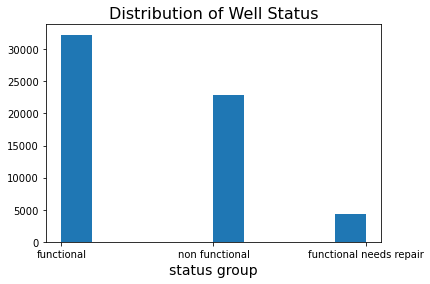

In [10]:
# Plot of the target status group

plt.hist(df_train_labels['status_group'])
plt.xlabel('status group', fontsize=14)
plt.title("Distribution of Well Status", fontsize=16)
plt.show()


## TO DO: Deal with Class Imbalance

# Data Preparation

#### The data contains features with very similar categories. Let’s choose only one of them. Since there is not much data in the dataset, we leave the feature with the smallest set of categories. Delete scheme_management, quantity_group, water_quality, payment_type, extraction_type, waterpoint_type_group, region_code.

#### The features scheme_management, quantity_group, water_quality, region_code, payment_type, extraction_type, waterpoint_type_group, date_recorded, and recorded_by will be deleted for duplicate information.

## Missing Values

#### Permit

In [15]:
df_train_set['permit'].value_counts(normalize=True,dropna=False)

True     0.654074
False    0.294478
NaN      0.051448
Name: permit, dtype: float64

In [16]:
# df_train_set.subvillage.fillna(0, inplace=True)
df_train_set.permit.fillna(0, inplace=True)
# df_train_set.public_meeting.fillna(0, inplace=True)
# df_train_set.scheme_management.fillna(0, inplace=True)

In [17]:
df_train_set['permit'].value_counts(normalize=True,dropna=False)

True     0.654074
False    0.345926
Name: permit, dtype: float64

In [18]:
#Make Permit boolean
df_train_set['permit'] = df_train_set['permit'].map(lambda x: 1 if x ==True else 0)
df_train_set['permit'].value_counts(normalize=True)

1    0.654074
0    0.345926
Name: permit, dtype: float64

## Replace mispellings and group smaller categories


### Reformat Installer col

In [19]:
df_train_set['installer'] = df_train_set['installer'].astype(str).str.lower()
df_train_set['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [20]:
df_train_set['installer'].value_counts(normalize=True)

dwe               0.293013
other             0.074663
government        0.031835
hesawa            0.023485
rwe               0.020303
                    ...   
cefa/rc church    0.000017
dwe/tassaf        0.000017
masjid takuar     0.000017
napupanga         0.000017
maj mugumu        0.000017
Name: installer, Length: 1934, dtype: float64

In [21]:
df_clean=pd.read_csv('data/lookups.csv')
df_train_set = pd.merge(df_train_set, df_clean, how='left', left_on='installer', right_on='installer_old')
df_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_old,installer_new
0,69572,6000.0,2011-03-14,Roman,1390,roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,NaN
1,8776,0.0,2013-03-06,Grumeti,1399,grumeti,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,NaN
2,34310,25.0,2013-02-25,Lottery Club,686,world vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,NaN,NaN
3,67743,0.0,2013-01-28,Unicef,263,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,NaN,NaN
4,19728,0.0,2011-07-13,Action In A,0,artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,NaN


In [22]:
df_train_set['installer_new'].isna().sum()

44958

In [23]:
df_train_set['installer'].value_counts(normalize=True)

dwe               0.293013
other             0.074663
government        0.031835
hesawa            0.023485
rwe               0.020303
                    ...   
cefa/rc church    0.000017
dwe/tassaf        0.000017
masjid takuar     0.000017
napupanga         0.000017
maj mugumu        0.000017
Name: installer, Length: 1934, dtype: float64

In [24]:
df_train_set['installer_new'].fillna(df_train_set['installer'], inplace=True)

df_train_set

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_old,installer_new
0,69572,6000.0,2011-03-14,Roman,1390,roman,34.938093,-9.856322,none,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,roman
1,8776,0.0,2013-03-06,Grumeti,1399,grumeti,34.698766,-2.147466,Zahanati,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,grumeti
2,34310,25.0,2013-02-25,Lottery Club,686,world vision,37.460664,-3.821329,Kwa Mahundi,0,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,NaN,world vision
3,67743,0.0,2013-01-28,Unicef,263,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,NaN,unicef
4,19728,0.0,2011-07-13,Action In A,0,artisan,31.130847,-1.825359,Shuleni,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN,artisan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,ces,37.169807,-3.253847,Area Three Namba 27,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,ces
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,NaN,cefa
59397,37057,0.0,2011-04-11,NaN,0,other,34.017087,-8.750434,Mashine,0,...,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,other,other
59398,31282,0.0,2011-03-08,Malec,0,musa,35.861315,-6.378573,Mshoro,0,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,NaN,musa


In [25]:
df_train_set['installer_new'].isna().sum()

0

In [26]:
df_train_set['installer_new'].value_counts(normalize=True)

dwe                           0.304983
other                         0.074663
tanzanian government          0.062323
community                     0.033266
danida                        0.028300
                                ...   
besado                        0.000017
mgaya                         0.000017
saxon building contractors    0.000017
twende pamoja                 0.000017
lc                            0.000017
Name: installer_new, Length: 1652, dtype: float64

In [27]:
del df_train_set['installer']
del df_train_set['installer_old']

In [28]:
df_installer_cnt = df_train_set['installer_new'].value_counts(normalize=True)
df_installer_cnt

dwe                           0.304983
other                         0.074663
tanzanian government          0.062323
community                     0.033266
danida                        0.028300
                                ...   
besado                        0.000017
mgaya                         0.000017
saxon building contractors    0.000017
twende pamoja                 0.000017
lc                            0.000017
Name: installer_new, Length: 1652, dtype: float64

In [29]:
df_installer_cnt.head(20)

dwe                     0.304983
other                   0.074663
tanzanian government    0.062323
community               0.033266
danida                  0.028300
hesawa                  0.023620
council                 0.022929
rwe                     0.020303
church                  0.016330
kkkt                    0.015623
finw                    0.013199
tcrs                    0.012458
world vision            0.012037
ces                     0.010269
amref                   0.007458
lga                     0.006953
tasaf                   0.006919
wedeco                  0.006700
dmdd                    0.006330
norad                   0.006162
Name: installer_new, dtype: float64

In [30]:
other_list = df_installer_cnt[df_installer_cnt<.01].index.tolist()
other_list

['amref',
 'lga',
 'tasaf',
 'wedeco',
 'dmdd',
 'norad',
 'unicef',
 'twesa',
 'da',
 'wu',
 'acra',
 'sema',
 'jaica',
 'oxfam',
 'shipo',
 'local',
 'idara ya maji',
 'villagers',
 'sengerema water department',
 'kiliwater',
 'dh',
 'kuwait',
 'distri',
 'lawatefuka water sup',
 'magadini-makiwaru wa',
 'fw',
 'centr',
 'private',
 'wvt',
 'mwe',
 'is',
 'handeni trunk main(',
 'water aid',
 'world bank',
 'wananchi',
 'rwssp',
 'jica',
 'adra',
 'artisan',
 'isf',
 'ddca',
 'world',
 'he',
 'african group',
 'tardo',
 'ir',
 'consulting engineer',
 'twe',
 'muwsa',
 'ded',
 'wizara ya maji',
 'halmashauri ya wilaya sikonge',
 'hsw',
 'go',
 'ki',
 'angli',
 'oxfarm',
 'roman',
 'vwc',
 'cefa',
 'h',
 'mdrdp',
 'aict',
 'water board',
 'region water department',
 'chamavita',
 'water',
 'lwi',
 'wa',
 'gtz',
 'villa',
 'mtn',
 'dawasco',
 'tassaf',
 'ncaa',
 'losaa-kia water supp',
 'wachina',
 'lvia',
 'wanan',
 'rdc',
 'gen',
 'tlc',
 'co',
 'priva',
 'st',
 'dhv',
 'pr',
 'cdtf',

In [31]:
df_train_set['installer_new'].replace(to_replace=other_list, value='other', inplace=True)
df_train_set['installer_new'].value_counts(normalize=True)

other                   0.424360
dwe                     0.304983
tanzanian government    0.062323
community               0.033266
danida                  0.028300
hesawa                  0.023620
council                 0.022929
rwe                     0.020303
church                  0.016330
kkkt                    0.015623
finw                    0.013199
tcrs                    0.012458
world vision            0.012037
ces                     0.010269
Name: installer_new, dtype: float64

In [32]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

### Reformat Funder col

In [33]:
df_train_set['funder'] = df_train_set['funder'].astype(str).str.lower()
df_train_set['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)

In [34]:
df_train_set['funder'].value_counts(normalize=True)

government of tanzania    0.152929
other                     0.074276
danida                    0.052424
hesawa                    0.037071
rwssp                     0.023131
                            ...   
kanisa la mitume          0.000017
msikitini                 0.000017
member o                  0.000017
frankfurt                 0.000017
mzee lesilali             0.000017
Name: funder, Length: 1897, dtype: float64

In [35]:
df_clean_funder=pd.read_csv('data/lookups_funder.csv')
df_train_set = pd.merge(df_train_set, df_clean_funder, how='left', left_on='funder', right_on='funder_old')
df_train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_new,funder_old,funder_new
0,69572,6000.0,2011-03-14,roman,1390,34.938093,-9.856322,none,0,Lake Nyasa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,other,NaN,NaN
1,8776,0.0,2013-03-06,grumeti,1399,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,NaN
2,34310,25.0,2013-02-25,lottery club,686,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,world vision,NaN,NaN
3,67743,0.0,2013-01-28,unicef,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,other,NaN,NaN
4,19728,0.0,2011-07-13,action in a,0,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,NaN


In [36]:
df_train_set['funder_new'].isna().sum()

39498

In [37]:
df_train_set['funder'].value_counts(normalize=True)

government of tanzania    0.152929
other                     0.074276
danida                    0.052424
hesawa                    0.037071
rwssp                     0.023131
                            ...   
kanisa la mitume          0.000017
msikitini                 0.000017
member o                  0.000017
frankfurt                 0.000017
mzee lesilali             0.000017
Name: funder, Length: 1897, dtype: float64

In [38]:
df_train_set['funder_new'].fillna(df_train_set['funder'], inplace=True)

df_train_set

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,installer_new,funder_old,funder_new
0,69572,6000.0,2011-03-14,roman,1390,34.938093,-9.856322,none,0,Lake Nyasa,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,other,NaN,roman
1,8776,0.0,2013-03-06,grumeti,1399,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,grumeti
2,34310,25.0,2013-02-25,lottery club,686,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,world vision,NaN,lottery club
3,67743,0.0,2013-01-28,unicef,263,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,other,NaN,unicef
4,19728,0.0,2011-07-13,action in a,0,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,other,NaN,action in a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,germany republi,1210,37.169807,-3.253847,Area Three Namba 27,0,Pangani,...,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,ces,germany republi,german group
59396,27263,4700.0,2011-05-07,cefa-njombe,1212,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,...,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,other,NaN,cefa-njombe
59397,37057,0.0,2011-04-11,other,0,34.017087,-8.750434,Mashine,0,Rufiji,...,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,other,NaN,other
59398,31282,0.0,2011-03-08,malec,0,35.861315,-6.378573,Mshoro,0,Rufiji,...,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,other,NaN,malec


In [39]:
df_train_set['funder_new'].isna().sum()

0

In [40]:
df_train_set['funder_new'].value_counts(normalize=True)

government       0.156869
other            0.074276
danida           0.052559
hesawa           0.037323
kkkt             0.026027
                   ...   
padep(mifugo)    0.000017
ju               0.000017
ester ndege      0.000017
ilo/undp         0.000017
mzee lesilali    0.000017
Name: funder_new, Length: 1683, dtype: float64

In [41]:
del df_train_set['funder']
del df_train_set['funder_old']

In [42]:
df_installer_cnt_funder = df_train_set['funder_new'].value_counts(normalize=True)
df_installer_cnt_funder

government       0.156869
other            0.074276
danida           0.052559
hesawa           0.037323
kkkt             0.026027
                   ...   
padep(mifugo)    0.000017
ju               0.000017
ester ndege      0.000017
ilo/undp         0.000017
mzee lesilali    0.000017
Name: funder_new, Length: 1683, dtype: float64

In [43]:
df_installer_cnt_funder.head(20)

government            0.156869
other                 0.074276
danida                0.052559
hesawa                0.037323
kkkt                  0.026027
district council      0.025051
church                0.024529
rwssp                 0.023131
world bank            0.022710
world vision          0.021498
unicef                0.019798
tasaf                 0.014764
dhv                   0.013956
private individual    0.013906
dwsp                  0.013653
norad                 0.012879
finw                  0.012559
german group          0.012492
tcrs                  0.010455
ministry of water     0.009933
Name: funder_new, dtype: float64

In [44]:
other_list_funder = df_installer_cnt_funder[df_installer_cnt_funder<.01].index.tolist()
other_list_funder

['ministry of water',
 'water',
 'dwe',
 'netherlands',
 'hifab',
 'adb',
 'lga',
 'amref',
 'oxfam',
 'wateraid',
 'isf',
 'rudep',
 'private',
 'jaica',
 'roman',
 'rural water supply and sanitat',
 'community',
 'adra',
 'ces(gmbh)',
 'jica',
 'shipo',
 'wsdp',
 'dh',
 'ded',
 'plan int',
 'kiliwater',
 'dmdd',
 'go',
 'lawatefuka water supply',
 'oxfarm',
 'magadini-makiwaru water',
 'fw',
 'w.b',
 'ces (gmbh)',
 'wvt',
 'oikos e.afrika',
 'nethalan',
 'lvia',
 'concern world wide',
 'unhcr',
 'no',
 'swedish',
 'african',
 'he',
 'is',
 'ki',
 'ir',
 'tardo',
 'wananchi',
 'snv',
 'roman catholic',
 'wua',
 'bsf',
 'tassaf',
 'islamic group',
 'co',
 'lamp',
 'dfid',
 'concern',
 'muwsa',
 'villagers',
 'ru',
 'halmashauri ya wilaya sikonge',
 'hsw',
 'twe',
 'idc',
 'tanza',
 'undp',
 'mdrdp',
 'h',
 'aict',
 'gtz',
 'japan',
 'cmsr',
 'ndrdp',
 'vwc',
 'lwi',
 'kuwait',
 'caritas',
 'cdtf',
 'kaemp',
 'padep',
 'marafip',
 'conce',
 'water aid /sema',
 'cefa',
 'ncaa',
 'nationa

In [45]:
df_train_set['funder_new'].replace(to_replace=other_list_funder, value='other', inplace=True)
df_train_set['funder_new'].value_counts(normalize=True)

other                 0.485842
government            0.156869
danida                0.052559
hesawa                0.037323
kkkt                  0.026027
district council      0.025051
church                0.024529
rwssp                 0.023131
world bank            0.022710
world vision          0.021498
unicef                0.019798
tasaf                 0.014764
dhv                   0.013956
private individual    0.013906
dwsp                  0.013653
norad                 0.012879
finw                  0.012559
german group          0.012492
tcrs                  0.010455
Name: funder_new, dtype: float64

### Group Other Remaining Columns

In [46]:
def group_other(col,perc):
    df_train_set[col] = df_train_set[col].astype(str).str.lower()
    df_cnt = df_train_set[col].value_counts(normalize=True)
    other_list = df_cnt[df_cnt<perc].index.tolist()
    

    return df_train_set[col].replace(to_replace=other_list, value='other', inplace=True)
    print(df_train_set[col].value_counts(normalize=True,dropna=False))

#### lga

In [47]:
df_train_set['lga'].value_counts(normalize=True,dropna=False)

Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: lga, Length: 125, dtype: float64

In [48]:
group_other('lga',.01)

In [49]:
df_train_set['lga'].value_counts(normalize=True,dropna=False)

other            0.475438
njombe           0.042138
arusha rural     0.021077
moshi rural      0.021061
bariadi          0.019815
rungwe           0.018620
kilosa           0.018418
kasulu           0.017626
mbozi            0.017407
meru             0.016987
bagamoyo         0.016785
singida rural    0.016751
kilombero        0.016145
same             0.014764
kibondo          0.014714
kyela            0.014461
kahama           0.014074
kigoma rural     0.013872
magu             0.013872
maswa            0.013620
karagwe          0.012980
mbinga           0.012626
iringa rural     0.012256
serengeti        0.012054
lushoto          0.011684
namtumbo         0.011684
songea rural     0.011667
mpanda           0.011431
mvomero          0.011296
ngara            0.011263
ulanga           0.011195
makete           0.010606
kwimba           0.010556
mbarali          0.010539
hai              0.010522
rombo            0.010000
Name: lga, dtype: float64

## Categorical and Numerical

In [52]:
categorical = ['basin','region_code', 'district_code', 'lga','permit','construction_year',
               'extraction_type_group','management','management_group', 'payment', 
               'quality_group', 'quantity','source_type','source_class', 'waterpoint_type',
               'installer_new', 'funder_new']
#longitude, lattitude

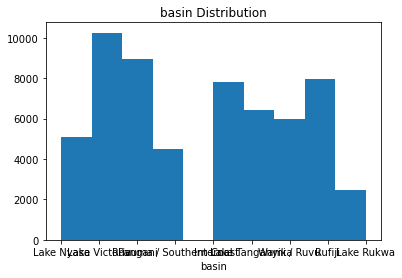

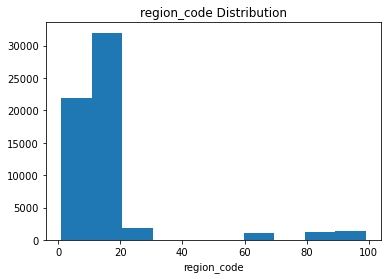

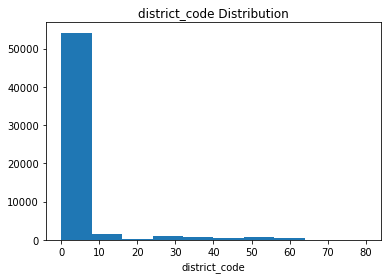

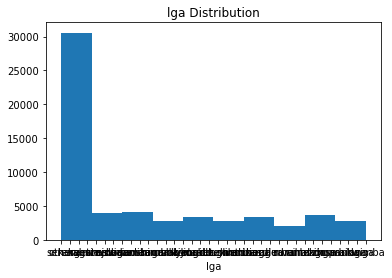

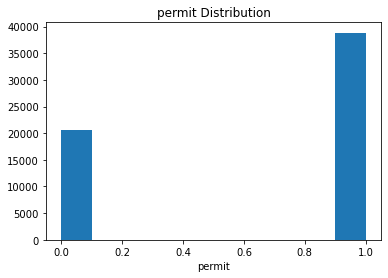

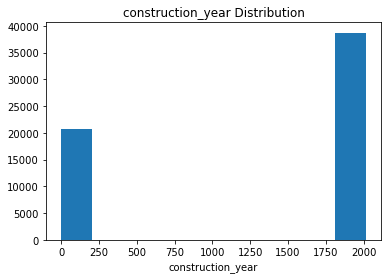

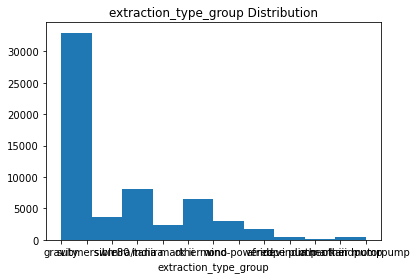

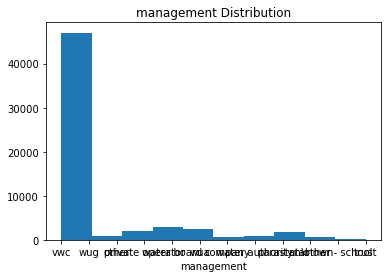

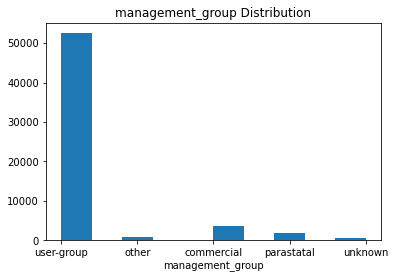

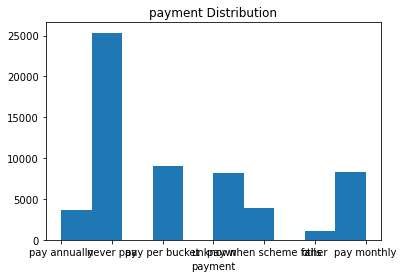

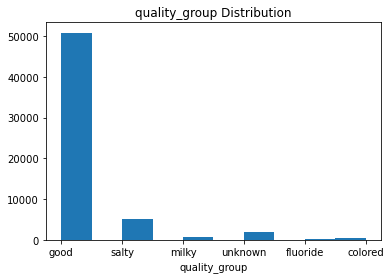

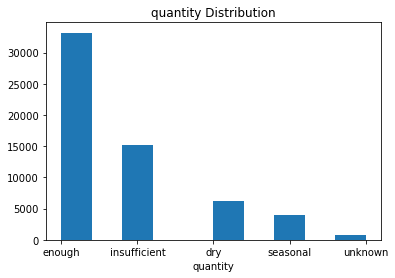

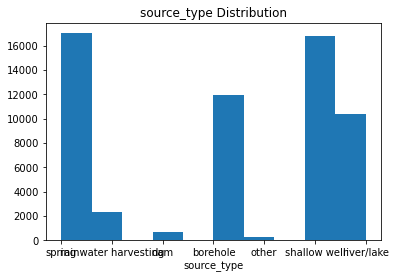

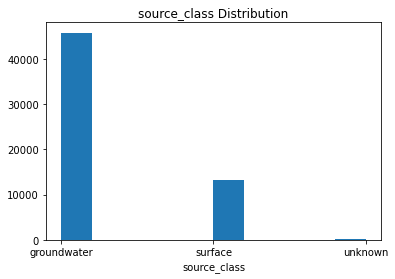

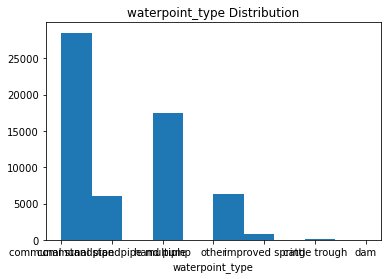

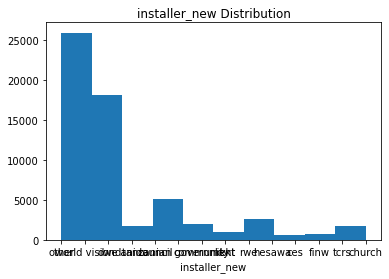

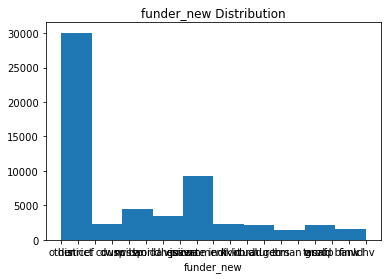

In [53]:
for column in categorical:
    plt.hist(df_train_set[column])
    plt.xlabel(column)
    plt.title("{} Distribution".format(column))
    plt.show()

In [54]:
df_train = df_train_set.join(df_train_labels, on='id', how='left', lsuffix='_left', rsuffix='_right')
df_train = drop(df_train)

df_test = drop(df_test)

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_left                59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   num_private            59400 non-null  int64  
 6   basin                  59400 non-null  object 
 7   region_code            59400 non-null  int64  
 8   district_code          59400 non-null  int64  
 9   lga                    59400 non-null  object 
 10  population             59400 non-null  int64  
 11  permit                 59400 non-null  int64  
 12  construction_year      59400 non-null  int64  
 13  extraction_type_group  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

In [56]:
df_train.columns

Index(['id_left', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'basin', 'region_code', 'district_code', 'lga',
       'population', 'permit', 'construction_year', 'extraction_type_group',
       'management', 'management_group', 'payment', 'quality_group',
       'quantity', 'source_type', 'source_class', 'waterpoint_type',
       'installer_new', 'funder_new', 'id_right', 'status_group'],
      dtype='object')

In [57]:
df_train['status_group'].value_counts(normalize=True,dropna=False)

functional                 0.436229
non functional             0.305522
NaN                        0.200471
functional needs repair    0.057778
Name: status_group, dtype: float64

In [58]:
df_train.loc[df_train['amount_tsh'] == 0]

,id_left,amount_tsh,gps_height,longitude,latitude,num_private,basin,region_code,district_code,lga,...,payment,quality_group,quantity,source_type,source_class,waterpoint_type,installer_new,funder_new,id_right,status_group
1,8776,0.0,1399,34.698766,-2.147466,0,Lake Victoria,20,2,serengeti,...,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,other,other,13732.0,non functional
3,67743,0.0,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,90,63,other,...,never pay,good,dry,borehole,groundwater,communal standpipe multiple,other,unicef,NaN,NaN
4,19728,0.0,0,31.130847,-1.825359,0,Lake Victoria,18,1,karagwe,...,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,other,other,45242.0,functional
6,19816,0.0,0,33.362410,-3.766365,0,Internal,17,3,other,...,never pay,good,enough,borehole,groundwater,hand pump,dwe,dwsp,3055.0,non functional
7,54551,0.0,0,32.620617,-4.226198,0,Lake Tanganyika,17,3,kahama,...,unknown,milky,enough,shallow well,groundwater,hand pump,dwe,rwssp,59779.0,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,40607,0.0,0,33.009440,-8.520888,0,Lake Rukwa,12,1,other,...,never pay,good,enough,spring,groundwater,communal standpipe,tanzanian government,government,9606.0,non functional
59393,48348,0.0,0,33.866852,-4.287410,0,Internal,14,2,other,...,pay per bucket,good,insufficient,dam,surface,other,other,other,33124.0,functional
59397,37057,0.0,0,34.017087,-8.750434,0,Rufiji,12,7,mbarali,...,pay monthly,fluoride,enough,borehole,groundwater,hand pump,other,other,57735.0,functional
59398,31282,0.0,0,35.861315,-6.378573,0,Rufiji,1,4,other,...,never pay,good,insufficient,shallow well,groundwater,hand pump,other,other,9495.0,functional


In [59]:
numerical = ['amount_tsh','gps_height','population']

In [60]:
numerical_large = ['gps_height','population']

In [61]:
numerical_small = ['amount_tsh']

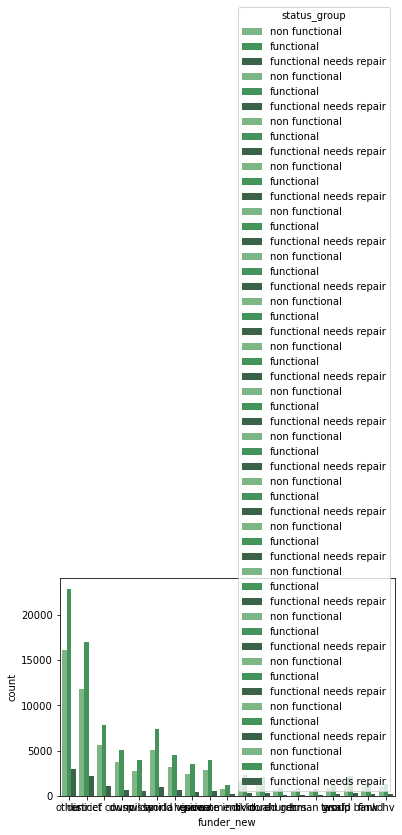

In [62]:
for column in categorical:
    sns.countplot(x=df_train[column], hue=df_train['status_group'], data=df_train, palette="Greens_d")
#     df_house.plot.scatter(x=column, y='price')
#     plt.title("{} vs. Sales Price".format(column))
#     plt.show()

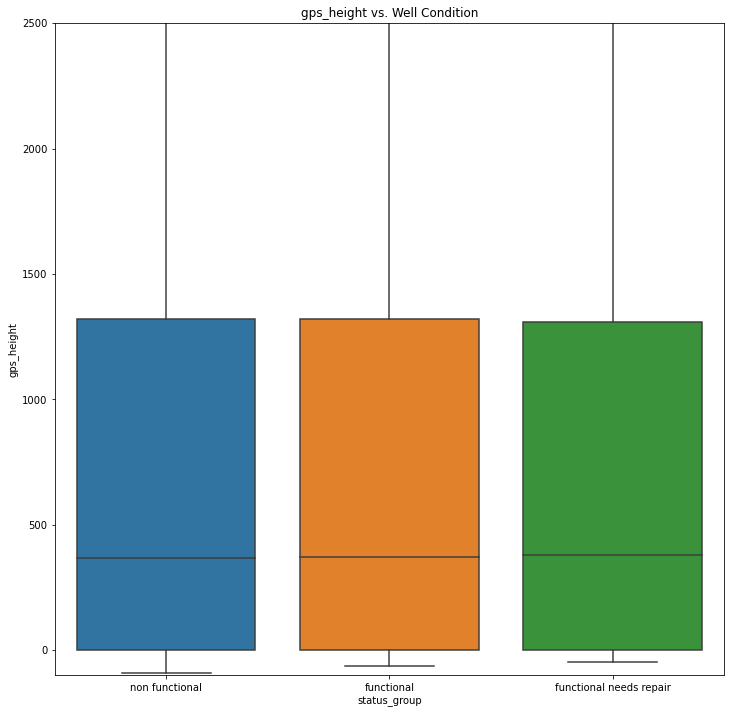

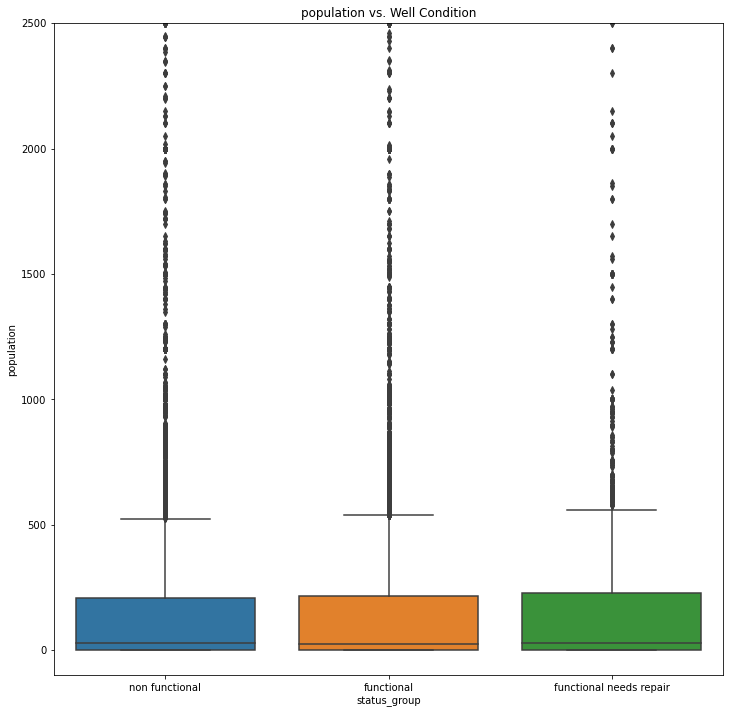

In [63]:
for variable in numerical_large:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(-100,2500)
    sns.boxplot(x='status_group', y=variable, data=df_train)
    plt.title("{} vs. Well Condition".format(variable))

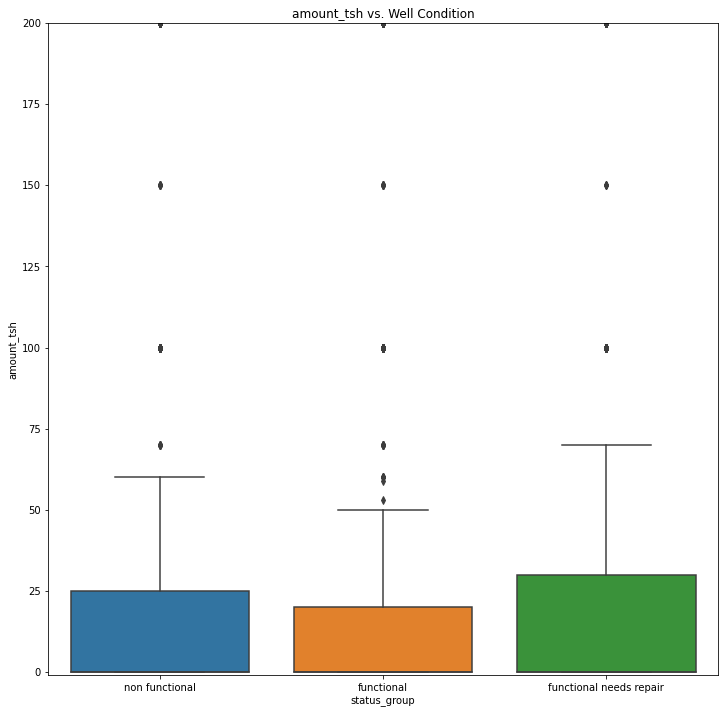

In [64]:
for variable in numerical_small:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(-1,200)
    sns.boxplot(x='status_group', y=variable, data=df_train)
    plt.title("{} vs. Well Condition".format(variable))

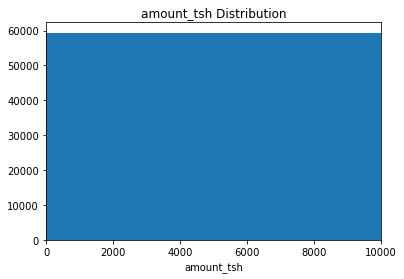

In [65]:
for column in numerical_small:
    plt.hist(df_train_set[column])
    plt.xlabel(column)
    plt.title("{} Distribution".format(column))
    plt.xlim(0,10000)
    plt.show()

### Column Binning

In [50]:
df_train_set['construction_year'].value_counts(normalize=True,dropna=False)

0       0.348636
2010    0.044529
2008    0.043990
2009    0.042643
2000    0.035202
2007    0.026717
2006    0.024764
2003    0.021650
2011    0.021145
2004    0.018906
2012    0.018249
2002    0.018098
1978    0.017458
1995    0.017071
2005    0.017020
1999    0.016481
1998    0.016263
1990    0.016061
1985    0.015909
1980    0.013653
1996    0.013653
1984    0.013114
1982    0.012525
1994    0.012424
1972    0.011919
1974    0.011380
1997    0.010842
1992    0.010774
1993    0.010236
2001    0.009091
1988    0.008771
1983    0.008215
1975    0.007357
1986    0.007306
1976    0.006970
1970    0.006919
1991    0.005455
1989    0.005320
1987    0.005084
1981    0.004007
1977    0.003401
1979    0.003232
1973    0.003098
2013    0.002963
1971    0.002441
1960    0.001717
1967    0.001481
1963    0.001431
1968    0.001296
1969    0.000993
1964    0.000673
1962    0.000505
1961    0.000354
1965    0.000320
1966    0.000286
Name: construction_year, dtype: float64

In [51]:
df_train_set['amount_tsh'].value_counts(normalize=True,dropna=False)

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

In [66]:
df_train['population'].value_counts(normalize=True,dropna=False)

0       0.359949
1       0.118266
200     0.032660
150     0.031852
250     0.028300
          ...   
3241    0.000017
1960    0.000017
1685    0.000017
2248    0.000017
1439    0.000017
Name: population, Length: 1049, dtype: float64

In [ ]:
# and we will also take a look at their summary statistics
for column in categorical_bin:
    print(df_house[column].describe())


<AxesSubplot:xlabel='amount_tsh', ylabel='count'>

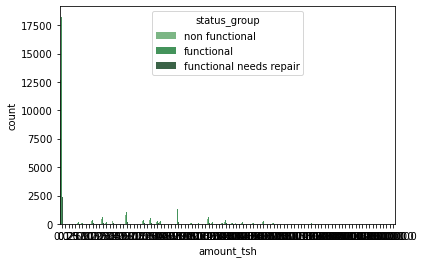

In [67]:
sns.countplot(x=df_train['amount_tsh'], hue=df_train['status_group'], data=df_train, palette="Greens_d")

## Columns to drop

### Mostly Empty

In [11]:
df_train_set['num_private'].value_counts(normalize=True,dropna=False)

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

### Many Individual Values

In [12]:
df_train_set['wpt_name'].value_counts(normalize=True,dropna=False)

none               0.059983
Shuleni            0.029428
Zahanati           0.013973
Msikitini          0.009007
Kanisani           0.005438
                     ...   
Kongowe Stand      0.000017
Ifwenkenya         0.000017
Kwa Pato Haweda    0.000017
Mwamanongu A       0.000017
Kwamtambalika      0.000017
Name: wpt_name, Length: 37400, dtype: float64

In [13]:
df_train_set['ward'].value_counts(normalize=True,dropna=False)

Igosi        0.005168
Imalinyi     0.004242
Siha Kati    0.003906
Mdandu       0.003889
Nduruma      0.003653
               ...   
Nyamtinga    0.000017
Simbay       0.000017
Linda        0.000017
Korongoni    0.000017
Igogo        0.000017
Name: ward, Length: 2092, dtype: float64

### Many Individual Values

In [14]:
def drop(df):
# Columns to drop
#     df = df.copy()
    df.drop([
        'scheme_management', 'quantity_group', 'water_quality', 'region', 'payment_type',
        'extraction_type', 'extraction_type_class','source','waterpoint_type_group', 'date_recorded', 'recorded_by',
        'subvillage', 'public_meeting', 'scheme_name','wpt_name','ward'],
        axis=1, inplace=True)
    return df
    

To do: look at feat importance of different geographic features remaining

- basin — Geographic water basin
- subvillage — Geographic location
- region_code — Geographic location (coded)
- district_code — Geographic location (coded)
- lga — Geographic location
- ward — Geographic location

### Encode Features

In [68]:
df_train.status_group.fillna(0, inplace=True)

In [69]:
df_train.columns

Index(['id_left', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'basin', 'region_code', 'district_code', 'lga',
       'population', 'permit', 'construction_year', 'extraction_type_group',
       'management', 'management_group', 'payment', 'quality_group',
       'quantity', 'source_type', 'source_class', 'waterpoint_type',
       'installer_new', 'funder_new', 'id_right', 'status_group'],
      dtype='object')

In [69]:
col_names = list(df_train.columns)
# col_names = col_names.remove('permit','id_left','id_right','status_group')

In [70]:
remove_ohe = ['permit','id_left','id_right','status_group']

In [71]:
col_names_ohe = col_names

In [76]:
for ele in col_names_ohe:
    if ele in remove_ohe:
        col_names_ohe.remove(ele)
col_names_ohe

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'basin',
 'region_code',
 'district_code',
 'lga',
 'population',
 'construction_year',
 'extraction_type_group',
 'management',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source_type',
 'source_class',
 'waterpoint_type',
 'installer_new',
 'funder_new']

In [73]:
X=df_train.drop(columns = ['id_right','id_left', 'status_group']) # Features
y=df_train['status_group']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [77]:
X_train[col_names] = X_train[col_names].astype('category')
X_test[col_names] = X_test[col_names].astype('category')


In [78]:
## one hot encode categoricals training set
X_train_ohe = pd.get_dummies(X_train[col_names])
X_train_ohe.head()

KeyboardInterrupt: 

In [ ]:
## Concatenate OHE columns with original dataframe, dropping OHE original features
X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_train.drop(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude','population', 
             'quantity', 'district_code', 'lga', 'ward','construction_year','extraction_type_group', 
             'management', 'management_group', 'payment','quality_group', 'source_type', 'source_class',
             'waterpoint_type','wpt_name', 'num_private', 'basin', 'region'], axis=1, inplace=True)
X_train.head()

In [ ]:
## one hot encode categoricals test set
X_test_ohe = pd.get_dummies(X_test[col_names])
X_test_ohe.head()

In [ ]:
## Concatenate OHE columns with original dataframe, dropping OHE original features
X_test = pd.concat([X_test, X_test_ohe], axis=1)
X_test.drop(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude','population', 
             'quantity', 'district_code', 'lga', 'ward','construction_year','extraction_type_group', 
             'management', 'management_group', 'payment','quality_group', 'source_type', 'source_class',
             'waterpoint_type','wpt_name', 'num_private', 'basin', 'region'], axis=1, inplace=True)
X_test.head()

### Adjust Class Imbalance

In [ ]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

# Model Development

## Baseline model with dummy classifier

## Random Forest Classifier

In [ ]:
clf=RandomForestClassifier(n_estimators=10)

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## xgboost

### Next model steps:  adding new features, choosing the model’s optimal parameters

### Featue Importance

### Feature Engineering

# Conclusions

# Business Recommendations

- no assumption for normality of residuals
- class imbalance
    - setting a balance metric or using smotenc (inside the model there is a parameter called class weights which can be set to balance) logistic reg study group
- Think about what metrics you are using and why
- Data Prep is key
- not as many assumptions for classifiers vs lin reg
- Do around 3 - 4 different types of models
- 3 vanilla models, check performance
- eg rand forest check feat importance
- xgboost
- 
- check for overfit
- see a baseline model usually done with a dummy classifier sklearn.dummies
- preserve iterations which provide insight or key points of change



In [ ]:
# status_group vs categorical variables

# for variable in col_names:
#     ax, figure = plt.subplots(1,1,figsize=(12,12))
#     plt.ylim(0,2000000)
#     sns.countplot(y=variable, hue='status_group', data=df_train, palette="Greens_d")
#     plt.title("{} vs. Water Pump Condition".format(variable))
    
# sns.countplot(y='response', hue='age_group', data=df, palette="Greens_d")

In [ ]:
# def clean_funder(df):
# #     df = df.copy()
#     df['funder'] = df['funder'].astype(str).str.lower()
#     df['funder'].replace(
#         to_replace=(
#             'kkkt_makwale', 'kkkt-dioces ya pare', 'world vision/ kkkt', 'kkkt church',
#             'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme', 'kkkt canal', 'kkkt usa',
#             'kkkt mareu'),
#         value='kkkt', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'government of tanzania', 'norad /government', 'government/ community',
#             'cipro/government', 'isf/government', 'finidagermantanzania govt',
#             'government /tassaf', 'finida german tanzania govt', 'village government',
#             'tcrs /government', 'village govt', 'government/ world bank',
#             'danida /government', 'dhv/gove', 'concern /govern', 'vgovernment',
#             'lwi & central government', 'government /sda', 'koica and tanzania government',
#             'world bank/government', 'colonial government', 'misri government',
#             'government and community', 'concern/governm', 'government of misri',
#             'government/tassaf', 'government/school', 'government/tcrs', 'unhcr/government',
#             'government /world vision', 'norad/government'),
#         value='government', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'british colonial government', 'japan government', 'china government',
#             'finland government', 'belgian government', 'italy government',
#             'irish government', 'egypt government', 'iran gover', 'swedish', 'finland'),
#         value='foreign government', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'rc church', 'anglican church', 'rc churc', 'rc ch', 'rcchurch/cefa',
#             'irc', 'rc', 'churc', 'hw/rc', 'rc church/centr', 'pentecosta church',
#             'roman church', 'rc/mission', "ju-sarang church' and bugango",
#             'lutheran church', 'roman cathoric church', 'tag church ub', 'aic church',
#             'free pentecoste church of tanz', 'tag church', 'fpct church', 'rc cathoric',
#             'baptist church', 'morovian church', 'cefa/rcchurch', 'rc mission',
#             'bukwang church saints', 'agt church', 'church of disciples', 'rc mofu',
#             "gil cafe'church'", 'pentecostal church', 'bukwang church saint',
#             'eung am methodist church', 'rc/dwe', 'cg/rc', 'eung-am methodist church',
#             'rc missionary', 'sda church', 'methodist church', 'rc msufi',
#             'haidomu lutheran church', 'nazareth church', 'st magreth church',
#             'agape churc', 'rc missi', 'rc mi', 'rc njoro', 'world vision/rc church',
#             'pag church', 'batist church', 'full gospel church', 'nazalet church',
#             'dwe/anglican church', 'missi', 'mission', 'missionaries', 'cpps mission',
#             'cvs miss', 'grail mission kiseki bar', 'shelisheli commission', 'missionary',
#             'heri mission', 'german missionary', 'wamissionari wa kikatoriki',
#             'rc missionary', 'germany missionary', 'missio', 'neemia mission', 'rc missi',
#             'hydom luthelani', 'luthe', 'lutheran church',  'haydom lutheran hospital',
#             'village council/ haydom luther', 'lutheran', 'haidomu lutheran church',
#             'resolute golden pride project', 'resolute mininggolden pride',
#             'germany cristians'),
#         value='church', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'olgilai village community', 'commu', 'community', 'arab community',
#             'sekei village community', 'arabs community', 'village community',
#             'mtuwasa and community', 'ilwilo community', 'igolola community',
#             'ngiresi village community', 'marumbo community', 'village communi',
#             'comune di roma', 'comunity construction fund', 'community bank',
#             "oak'zion' and bugango b' commu", 'kitiangare village community',
#             'oldadai village community', 'tlc/community', 'maseka community',
#             'islamic community',  'tcrs/village community', 'buluga subvillage community',
#             'okutu village community'),
#         value='community', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'council', 'wb / district council', 'cdtfdistrict council',
#             'sangea district council', 'mheza distric counc', 'kyela council',
#             'kibaha town council', 'swidish', 'mbozi district council', 
#             'village council/ rose kawala',  'songea municipal counci',
#             'quick win project /council', 'village council', 'villege council',
#             'tabora municipal council', 'kilindi district co', 'kigoma municipal council',
#             'district council', 'municipal council', 'district medical',
#             'sengerema district council', 'town council', 'mkinga  distric cou',
#             'songea district council', 'district rural project', 'mkinga distric coun',
#             'dadis'),
#         value='district', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'tcrs.tlc', 'tcrs /care', 'tcrst', 'cipro/care/tcrs', 'tcrs/care', 'tcrs kibondo'),
#         value='tcrs', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'fini water', 'finw', 'fin water', 'finn water', 'finwater'),
#         value='fini', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'islamic', 'the isla', 'islamic found', 'islamic agency tanzania',
#             'islam', 'muislam', 'the islamic', 'nyabibuye islamic center', 'islamic society', 'african muslim agency',
#             'muslims', 'answeer muslim grou', 'muslimu society(shia)',
#             'unicef/african muslim agency', 'muslim world', 'muslimehefen international',
#             'shear muslim', 'muslim society'),
#         value='islam', inplace=True)
#     df['funder'].replace(
#         to_replace=('danida', 'ms-danish', 'unhcr/danida', 'tassaf/ danida'),
#         value='danida', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'hesawa', 'hesawz', 'hesaw', 'hhesawa', 'hesawwa', 'hesawza', 'hesswa',
#             'hesawa and concern world wide'),
#         value='hesawa', inplace=True)
#     df['funder'].replace(
#         to_replace=('world vision/adra', 'game division', 'worldvision'),
#         value='world vision', inplace=True)
#     df['funder'].replace(
#         to_replace=(
#             'germany republi', 'a/co germany', 'aco/germany', 'bingo foundation germany',
#             'africa project ev germany', 'tree ways german'),
#         value='germany', inplace=True)
#     df['funder'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
#     df_funder_cnt = df.groupby('funder')['funder'].count()
#     other_list = df_funder_cnt[df_funder_cnt<98].index.tolist()
#     df['funder'].replace(to_replace=other_list, value='other', inplace=True)
#     return df

In [ ]:
# def clean_installer(df):
#     """docstring instructions on what function does"""
#     df['installer'] = df['installer'].astype(str).str.lower()
#     df['installer'].replace(
#         to_replace=(
#             'fini water', 'fin water', 'finn water', 'finwater', 'finwate'),
#         value='finw', inplace=True)
#     df['installer'].replace(to_replace=('jaica co'), value='jaica', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'district water department', 'district water depar', 'district council',
#             'district counci', 'village council orpha','kibaha town council',
#             'village council', 'coun', 'village counil', 'council',
#             'mbulu district council', 'counc', 'village council .oda',
#             'sangea district coun', 'songea district coun', 'villege council',
#             'district  council', 'quick win project /council', 'mbozi district council',
#             'village  council', 'municipal council', 'tabora municipal council',
#             'wb / district council'),
#         value='council', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'rc church', 'rc churc', 'rcchurch/cefa', 'irc', 'rc', 'rc ch', 'hw/rc',
#             'rc church/central gover', 'kkkt church', 'pentecost church', 'roman church',
#             'rc/mission', 'rc church/cefa', 'lutheran church', 'tag church',
#             'free pentecoste church of tanz', 'rc c', 'church', 'rc cathoric',
#             'morovian church', 'cefa/rc church', 'rc mission', 'anglican church',
#             'church of disciples', 'anglikana church', 'cetral government /rc',
#             'pentecostal church', 'cg/rc', 'rc missionary', 'sda church', 'methodist church', 'trc',
#             'rc msufi', 'haidomu lutheran church', 'baptist church', 'rc church brother',
#             'st magreth church', 'anglica church', 'global resource co', 'rc mi',
#             'baptist church of tanzania', 'fpct church', 'rc njoro', 'rc .church',
#             'rc mis', 'batist church', 'churc', 'dwe/anglican church','missi', 'mission',
#             'ndanda missions', 'rc/mission', 'cvs miss', 'missionaries', 'hydom luthelani',
#             'luthe', 'haydom lutheran hospital', 'lutheran', 'missio', 'germany missionary',
#             'grail mission kiseki bar', 'missionary', 'heri mission', 'german missionsry',
#             'wamissionari wa kikatoriki', 'neemia mission', 'wamisionari wa kikatoriki'),
#         value='church', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'central government', 'gove', 'central govt', 'gover', 'cipro/government',
#             'governme', 'adra /government', 'isf/government', 'adra/government',
#             'government /tcrs', 'village govt', 'government', 'government /community',
#             'concern /government', 'goverm', 'village government', 'cental government',
#             'govern', 'cebtral government', 'government /sda', 'tcrs /government',
#             'tanzania government', 'centra govt', 'colonial government', 'misri government',
#             'government and community', 'cetral government /rc', 'concern/government',
#             'government of misri', 'lwi &central government', 'governmen', 'government/tcrs', 'government /world vision',
#             'centra government'),
#         value='tanzanian government', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'world vission', 'world division', 'word divisio','world visiin'),
#         value='world vision', inplace=True)
#     df['installer'].replace(to_replace=('unicrf'), value='unicef', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'commu', 'olgilai village community', 'adra /community', 'adra/community',
#             'rwe/ community', 'killflora /community', 'communit', 'taboma/community',
#             'arab community', 'adra/ community', 'sekei village community', 'rwe/community',
#             'arabs community', 'village community', 'government /community',
#             'dads/village community', 'killflora/ community', 'mtuwasa and community',
#             'rwe /community', 'ilwilo community', 'summit for water/community',
#             'igolola community', 'ngiresi village community', 'rwe community',
#             'african realief committe of ku', 'twesa /community', 'shelisheli commission',
#             'twesa/ community', 'marumbo community', 'government and community',
#             'community bank', 'kitiangare village community', 'oldadai village community',
#             'twesa/community', 'tlc/community', 'maseka community', 'islamic community',
#             'district community j', 'village water commission', 'village community members',
#             'tcrs/village community', 'village water committee', 'comunity'),
#         value='community', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'danid', 'danda','danida co', 'danny', 'daniad', 'dannida', 'danids'),
#         value='danida', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'hesaws', 'huches', 'hesaw', 'hesawz', 'hesawq', 'hesewa'),
#         value='hesawa', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'dwsp', 'kkkt _ konde and dwe', 'rwe/dwe', 'rwedwe', 'dwe/', 'dw', 'dwr',
#             'dwe}', 'dwt', 'dwe /tassaf', 'dwe/ubalozi wa marekani', 'consultant and dwe',
#             'dwe & lwi', 'ubalozi wa marekani /dwe', 'dwe&', 'dwe/tassaf', 'dw$',
#             'dw e', 'tcrs/dwe', 'dw#', 'dweb', 'tcrs /dwe', 'water aid/dwe', 'dww'),
#         value='dwe', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'africa muslim', 'muslimu society(shia)', 'africa muslim agenc',
#             'african muslims age', 'muslimehefen international','islamic',
#             'the isla', 'islamic agency tanzania',  'islam', 'nyabibuye islamic center'),
#         value='muslims', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'british colonial government', 'british government', 'britain'),
#         value='british', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'tcrs/tlc', 'tcrs /care', 'cipro/care/tcrs', 'tcrs kibondo', 'tcrs.tlc',
#             'tcrs /twesa', 'tassaf /tcrs', 'tcrs/care', 'tcrs twesa', 'rwe/tcrs',
#             'tcrs/twesa', 'tassaf/ tcrs', 'tcrs/ tassaf', 'tcrs/ twesa', 'tcrs a',
#             'tassaf/tcrs'),
#         value='tcrs', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'kkkt-dioces ya pare', 'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme',
#             'kkkt kilinga', 'kkkt canal', 'kkkt katiti juu', 'kkkt mareu'),
#         value='kkkt', inplace=True)
#     df['installer'].replace(to_replace=('norad/'), value='norad', inplace=True)
#     df['installer'].replace( to_replace=('tasaf/dmdd', 'dmdd/solider'),
#         value='dmdd', inplace=True)
#     df['installer'].replace(
#         to_replace=('cjejow construction', 'cjej0'), value='cjejow', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'china henan constuction', 'china henan contractor', 'china co.', 'chinese'),
#         value='china', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'local contract', 'local technician', 'local', 'local  technician',
#             'locall technician', 'local te', 'local technitian', 'local technical tec',
#             'local fundi', 'local technical', 'localtechnician', 'village local contractor',
#             'local l technician'),
#         value='local', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'oikos e .africa', 'oikos e.africa', 'africa amini alama',
#             'africa islamic agency tanzania', 'africare', 'african development foundation',
#             'oikos e. africa', 'oikos e.afrika', 'afroz ismail', 'africa', 'farm-africa',
#             'oikos e africa', 'farm africa', 'africaone', 'tina/africare', 'africaone ltd',
#             'african reflections foundation', 'africa m'),
#         value='africa', inplace=True)
#     df['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
#     df_installer_cnt = df.groupby('installer')['installer'].count()
#     other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
#     df['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [ ]:
# def clean_installer(df):
#     """docstring instructions on what function does"""
#     df['installer'] = df['installer'].astype(str).str.lower()
#     df['installer'].replace(
#         to_replace=(
#             'fini water', 'fin water', 'finn water', 'finwater', 'finwate'),
#         value='finw', inplace=True)
#     df['installer'].replace(to_replace=('jaica co'), value='jaica', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'district water department', 'district water depar', 'district council',
#             'district counci', 'village council orpha','kibaha town council',
#             'village council', 'coun', 'village counil', 'council',
#             'mbulu district council', 'counc', 'village council .oda',
#             'sangea district coun', 'songea district coun', 'villege council',
#             'district  council', 'quick win project /council', 'mbozi district council',
#             'village  council', 'municipal council', 'tabora municipal council',
#             'wb / district council'),
#         value='council', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'rc church', 'rc churc', 'rcchurch/cefa', 'irc', 'rc', 'rc ch', 'hw/rc',
#             'rc church/central gover', 'kkkt church', 'pentecost church', 'roman church',
#             'rc/mission', 'rc church/cefa', 'lutheran church', 'tag church',
#             'free pentecoste church of tanz', 'rc c', 'church', 'rc cathoric',
#             'morovian church', 'cefa/rc church', 'rc mission', 'anglican church',
#             'church of disciples', 'anglikana church', 'cetral government /rc',
#             'pentecostal church', 'cg/rc', 'rc missionary', 'sda church', 'methodist church', 'trc',
#             'rc msufi', 'haidomu lutheran church', 'baptist church', 'rc church brother',
#             'st magreth church', 'anglica church', 'global resource co', 'rc mi',
#             'baptist church of tanzania', 'fpct church', 'rc njoro', 'rc .church',
#             'rc mis', 'batist church', 'churc', 'dwe/anglican church','missi', 'mission',
#             'ndanda missions', 'rc/mission', 'cvs miss', 'missionaries', 'hydom luthelani',
#             'luthe', 'haydom lutheran hospital', 'lutheran', 'missio', 'germany missionary',
#             'grail mission kiseki bar', 'missionary', 'heri mission', 'german missionsry',
#             'wamissionari wa kikatoriki', 'neemia mission', 'wamisionari wa kikatoriki'),
#         value='church', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'central government', 'gove', 'central govt', 'gover', 'cipro/government',
#             'governme', 'adra /government', 'isf/government', 'adra/government',
#             'government /tcrs', 'village govt', 'government', 'government /community',
#             'concern /government', 'goverm', 'village government', 'cental government',
#             'govern', 'cebtral government', 'government /sda', 'tcrs /government',
#             'tanzania government', 'centra govt', 'colonial government', 'misri government',
#             'government and community', 'cetral government /rc', 'concern/government',
#             'government of misri', 'lwi &central government', 'governmen', 'government/tcrs', 'government /world vision',
#             'centra government'),
#         value='tanzanian government', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'world vission', 'world division', 'word divisio','world visiin'),
#         value='world vision', inplace=True)
#     df['installer'].replace(to_replace=('unicrf'), value='unicef', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'commu', 'olgilai village community', 'adra /community', 'adra/community',
#             'rwe/ community', 'killflora /community', 'communit', 'taboma/community',
#             'arab community', 'adra/ community', 'sekei village community', 'rwe/community',
#             'arabs community', 'village community', 'government /community',
#             'dads/village community', 'killflora/ community', 'mtuwasa and community',
#             'rwe /community', 'ilwilo community', 'summit for water/community',
#             'igolola community', 'ngiresi village community', 'rwe community',
#             'african realief committe of ku', 'twesa /community', 'shelisheli commission',
#             'twesa/ community', 'marumbo community', 'government and community',
#             'community bank', 'kitiangare village community', 'oldadai village community',
#             'twesa/community', 'tlc/community', 'maseka community', 'islamic community',
#             'district community j', 'village water commission', 'village community members',
#             'tcrs/village community', 'village water committee', 'comunity'),
#         value='community', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'danid', 'danda','danida co', 'danny', 'daniad', 'dannida', 'danids'),
#         value='danida', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'hesaws', 'huches', 'hesaw', 'hesawz', 'hesawq', 'hesewa'),
#         value='hesawa', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'dwsp', 'kkkt _ konde and dwe', 'rwe/dwe', 'rwedwe', 'dwe/', 'dw', 'dwr',
#             'dwe}', 'dwt', 'dwe /tassaf', 'dwe/ubalozi wa marekani', 'consultant and dwe',
#             'dwe & lwi', 'ubalozi wa marekani /dwe', 'dwe&', 'dwe/tassaf', 'dw$',
#             'dw e', 'tcrs/dwe', 'dw#', 'dweb', 'tcrs /dwe', 'water aid/dwe', 'dww'),
#         value='dwe', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'africa muslim', 'muslimu society(shia)', 'africa muslim agenc',
#             'african muslims age', 'muslimehefen international','islamic',
#             'the isla', 'islamic agency tanzania',  'islam', 'nyabibuye islamic center'),
#         value='muslims', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'british colonial government', 'british government', 'britain'),
#         value='british', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'tcrs/tlc', 'tcrs /care', 'cipro/care/tcrs', 'tcrs kibondo', 'tcrs.tlc',
#             'tcrs /twesa', 'tassaf /tcrs', 'tcrs/care', 'tcrs twesa', 'rwe/tcrs',
#             'tcrs/twesa', 'tassaf/ tcrs', 'tcrs/ tassaf', 'tcrs/ twesa', 'tcrs a',
#             'tassaf/tcrs'),
#         value='tcrs', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'kkkt-dioces ya pare', 'kkkt leguruki', 'kkkt ndrumangeni', 'kkkt dme',
#             'kkkt kilinga', 'kkkt canal', 'kkkt katiti juu', 'kkkt mareu'),
#         value='kkkt', inplace=True)
#     df['installer'].replace(to_replace=('norad/'), value='norad', inplace=True)
#     df['installer'].replace( to_replace=('tasaf/dmdd', 'dmdd/solider'),
#         value='dmdd', inplace=True)
#     df['installer'].replace(
#         to_replace=('cjejow construction', 'cjej0'), value='cjejow', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'china henan constuction', 'china henan contractor', 'china co.', 'chinese'),
#         value='china', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'local contract', 'local technician', 'local', 'local  technician',
#             'locall technician', 'local te', 'local technitian', 'local technical tec',
#             'local fundi', 'local technical', 'localtechnician', 'village local contractor',
#             'local l technician'),
#         value='local', inplace=True)
#     df['installer'].replace(
#         to_replace=(
#             'oikos e .africa', 'oikos e.africa', 'africa amini alama',
#             'africa islamic agency tanzania', 'africare', 'african development foundation',
#             'oikos e. africa', 'oikos e.afrika', 'afroz ismail', 'africa', 'farm-africa',
#             'oikos e africa', 'farm africa', 'africaone', 'tina/africare', 'africaone ltd',
#             'african reflections foundation', 'africa m'),
#         value='africa', inplace=True)
#     df['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
#     df_installer_cnt = df.groupby('installer')['installer'].count()
#     other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
#     df['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [ ]:
# df_train_set['installer'].replace(to_replace=('0', 'nan', '-'), value='other', inplace=True)
# df_installer_cnt = df_train_set.groupby('installer')['installer'].count()
# other_list = df_installer_cnt[df_installer_cnt<71].index.tolist()
# df_train_set['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [ ]:

# df_installer_cnt = df_train_set['installer'].value_counts(normalize=True)
# df_installer_cnt
# other_list = df_installer_cnt[df_installer_cnt<.05].index.tolist()
# other_list
# df_train_set['installer'].replace(to_replace=other_list, value='other', inplace=True)

In [ ]:
# def rename_similar_names_to_new_name(df, df_col, list_of_bad_names, new_name):
#     '''
#     Takes in a dataframe (df), 
#     column name (df_col),
#     a list of names that are similar (list_of_bad_names), 
#     a string that standardizes the name (new_name), and
#     returns a df where the given df_col has renamed simliar names to the new name
#     '''

#     df[df_col] = df[df_col].astype(str).str.lower()
#     df[df_col].replace(to_replace=list_of_bad_names,
#                             value=new_name, 
#                             inplace=True)
#     return df


In [ ]:
# df = rename_similar_names_to_new_name(df, 
#                                       'installer',
#                                       ['fini water', 'fin water', 'finn water', 'finwater', 'finwate'],
#                                      'fini')

In [ ]:
# ld = ['installer',
#       'installer',
#       'funder'
#      ]
# ll = [['fini water', 'fin water', 'finn water', 'finwater', 'finwate'],
#       ['sestew'],
#       ['er', 'klj']
#      ]
# lv = ['finw',
#       'a',
#       'b'
#      ]

In [ ]:
# def something_else(df, my_func, list_of_df_cols, my_lists, my_values):
#         '''
#     blah
#     '''
#     for i in range(0,len(list_of_df_cols)):
#         df = my_func(df, 
#                      list_of_df_cols[i],
#                      my_lists[i],
#                      my_values[i]
#                     )
#     return df


In [ ]:
# df = something_else(df, 
#                    rename_similar_names_to_new_name,
#                    ld,
#                    ll, 
#                    lv
#                   )

